In [ ]:
!pip install faiss-cpu
!pip install ragas==0.3.7
!pip install rouge-score

In [ ]:
import torch
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import time
import os
import pickle
from collections import Counter
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import ngrams

# --- Configuration ---
NUM_DOCUMENTS = 50000
INDEX_PATH = "faiss_index.bin"
DOCUMENTS_PATH = "documents.pkl"
EMBEDDING_MODEL = 'all-MiniLM-L6-v2'
GENERATOR_MODEL = "google/flan-t5-base"

# --- Setup Device (GPU if available) ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using device: {device}")

# --- Part 1: Data Loading and Index Building (with persistence) ---

if os.path.exists(INDEX_PATH) and os.path.exists(DOCUMENTS_PATH):
    # Load pre-built index and documents from disk
    print("✅ Loading existing index and documents from disk...")
    index = faiss.read_index(INDEX_PATH)
    with open(DOCUMENTS_PATH, "rb") as f:
        documents = pickle.load(f)
    print(f"✅ Loaded FAISS index with {index.ntotal} vectors and {len(documents)} documents.")
else:
    # --- Data Loading and Preprocessing ---
    print(f"🚀 Loading and preprocessing {NUM_DOCUMENTS} documents from KILT (ELI5)...")

    dataset = load_dataset("kilt_tasks", "eli5", split=f"train[:{NUM_DOCUMENTS}]")
    print("Columns:", dataset.column_names)
    print("Number of rows:", len(dataset))

    # --- Dataset Overview (to help reviewer understand) ---
    print("\n📊 --- Dataset Overview --- 📊")
    print("The KILT ELI5 dataset is a QA dataset designed for open-domain question answering.")
    print("Each row has:")
    print(" - 'id': unique identifier")
    print(" - 'input': the natural language question (user query)")
    print(" - 'output': list of possible reference answers (ground truth)")
    print(" - 'meta': metadata such as retrieval information\n")

    # Show top 5 rows to reviewer
    print("Top 5 rows of the dataset:")
    print(dataset.select(range(5)).to_pandas())

    # Check for missing values
    null_counts = {col: sum(1 for v in dataset[col] if v is None or v == '') for col in dataset.column_names}
    print("\nNull values per column:")
    for col, count in null_counts.items():
        print(f"{col}: {count}")

    # Explain how data is used in RAG
    print("\n📌 How RAG applies to this dataset:")
    print("1. Input (Question): We take the 'input' field (user’s natural question).")
    print("2. Document Table: We build a knowledge base (Document Table) from all answers in 'output'.")
    print("   - Each document is created by concatenating multiple answers into a single passage.")
    print("3. Retriever Stage: Given a question, we embed it and search the Document Table in FAISS for top-k relevant documents.")
    print("4. Generator Stage: We pass the question + top-k retrieved documents into the LLM (Flan-T5) to generate an answer.")
    print("5. Evaluation Stage: We compare the generated answer with the ground truth reference answers in 'output'.")

    # Clarify table relationship
    print("\n📂 Tables and Relationship:")
    print(" - Question-Answer Table: Original dataset with question ('input') and reference answers ('output').")
    print(" - Document Table: Constructed by concatenating answers; used for retrieval.")
    print("   -> One Question-Answer row can produce one Document in the Document Table.")

    # --- EDA: Sample entries ---
    print("\nSample entries:")
    for ex in dataset.shuffle().select(range(3)):
        print("Id:", ex["id"])
        print("Question:", ex["input"])
        print("Meta:", ex["meta"])
        print("Answers:", [o["answer"] for o in ex["output"]])
        print("-"*80)

    # --- Questions length distribution ---
    q_lengths = [len(q.split()) for q in dataset["input"]]
    print("\n" + "="*60)
    print("📊 QUESTION LENGTH STATISTICS")
    print("="*60)
    print(f"Minimum question length: {min(q_lengths)} words")
    print(f"Maximum question length: {max(q_lengths)} words")
    print(f"Average question length: {np.mean(q_lengths):.2f} words")
    print(f"Median question length: {np.median(q_lengths):.1f} words")
    print(f"Standard deviation: {np.std(q_lengths):.2f} words")
    print("="*60)

    plt.hist(q_lengths, bins=50, range=(0, 60))
    plt.title("Distribution of Question Lengths (in words)")
    plt.xlabel("Words per question")
    plt.ylabel("Count")
    plt.show()

    # --- Number of answers per question ---
    num_answers = [len(ex["output"]) for ex in dataset]

    print("\n" + "="*60)
    print("📊 NUMBER OF ANSWERS STATISTICS")
    print("="*60)
    print(f"Minimum answers per question: {min(num_answers)}")
    print(f"Maximum answers per question: {max(num_answers)}")
    print(f"Average answers per question: {np.mean(num_answers):.2f}")
    print(f"Median answers per question: {np.median(num_answers):.1f}")
    print(f"Standard deviation: {np.std(num_answers):.2f}")
    print(f"Questions with only 1 answer: {sum(1 for n in num_answers if n == 1)} ({sum(1 for n in num_answers if n == 1)/len(num_answers)*100:.1f}%)")
    print("="*60)

    plt.hist(num_answers, bins=30, range=(0, 30))
    plt.title("Distribution of #Answers per Question")
    plt.xlabel("# answers")
    plt.ylabel("Count")
    plt.show()

    # --- Document Creation (concatenate answers) ---
    documents = []
    for ex in dataset:
        answers = [o["answer"] for o in ex["output"]]
        doc = " ".join(answers)
        if len(doc.strip()) > 50:
            documents.append(doc)

    doc_lengths = [len(d.split()) for d in documents]

    print("\n" + "="*60)
    print("📊 DOCUMENT LENGTH STATISTICS")
    print("="*60)
    print(f"Total documents created: {len(documents)}")
    print(f"Documents kept (>50 words): {len(documents)}/{len(dataset)} ({len(documents)/len(dataset)*100:.1f}%)")
    print(f"Minimum document length: {min(doc_lengths)} words")
    print(f"Maximum document length: {max(doc_lengths)} words")
    print(f"Average document length: {np.mean(doc_lengths):.2f} words")
    print(f"Median document length: {np.median(doc_lengths):.1f} words")
    print(f"Standard deviation: {np.std(doc_lengths):.2f} words")
    print(f"95th percentile: {np.percentile(doc_lengths, 95):.1f} words")
    print("="*60)

    plt.hist(doc_lengths,  bins=100, range=(0, 5000))
    plt.title("Distribution of Document Lengths (in words)")
    plt.xlabel("Words per document")
    plt.ylabel("Count")
    plt.show()

    print(f"Kept {len(documents)} documents out of {len(dataset)} ({len(documents)/len(dataset):.2%})")

    # --- Text Statistics / Word Frequency Analysis ---
    all_text = " ".join(documents).lower()
    all_text = re.sub(r"[^a-zA-Z0-9\s]", "", all_text)
    words = all_text.split()
    stop_words = set(stopwords.words("english"))
    words_no_stop = [w for w in words if w not in stop_words]

    word_freq = Counter(words_no_stop)
    most_common_words = word_freq.most_common(20)
    print("\nMost common words (excluding stopwords):")
    for word, count in most_common_words:
        print(f"{word}: {count}")

    # WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(word_freq)
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("WordCloud of Top Words (Excluding Stopwords)")
    plt.show()

    # Top n-grams
    def top_ngrams(words_list, n=2, top_k=20):
        n_grams = ngrams(words_list, n)
        n_grams_freq = Counter(n_grams)
        return n_grams_freq.most_common(top_k)

    print("\nTop 20 Bigrams:")
    for gram, count in top_ngrams(words_no_stop, 2):
        print(f"{' '.join(gram)}: {count}")

    print("\nTop 20 Trigrams:")
    for gram, count in top_ngrams(words_no_stop, 3):
        print(f"{' '.join(gram)}: {count}")

    # --- Embedding Generation ---
    print(f"\n🚀 Loading embedding model '{EMBEDDING_MODEL}'...")
    embedding_model = SentenceTransformer(EMBEDDING_MODEL, device=device)

    print(f"⏳ Generating embeddings for {len(documents)} documents (this will take a while)...")
    start_time = time.time()
    doc_embeddings = embedding_model.encode(
        documents,
        convert_to_numpy=True,
        show_progress_bar=True,
        normalize_embeddings=True
    )
    end_time = time.time()
    print(f"✅ Embeddings generated in {end_time - start_time:.2f} seconds.")

    # --- FAISS Indexing ---
    print("⏳ Building FAISS index...")
    embedding_dim = doc_embeddings.shape[1]
    index = faiss.IndexFlatIP(embedding_dim)
    index.add(doc_embeddings.astype('float32'))
    print(f"✅ FAISS index built with {index.ntotal} vectors.")

    # --- Save the index and documents for future runs ---
    print("💾 Saving index and documents to disk...")
    faiss.write_index(index, INDEX_PATH)
    with open(DOCUMENTS_PATH, "wb") as f:
        pickle.dump(documents, f)
    print("✅ Saved successfully.")

# --- Part 2: The Retriever ---
print("\n🚀 Setting up the Retriever...")
embedding_model = SentenceTransformer(EMBEDDING_MODEL, device=device)

def retrieve_context(query, top_k=5):
    query_embedding = embedding_model.encode(
        [query],
        convert_to_numpy=True,
        normalize_embeddings=True
    ).astype('float32')

    distances, indices = index.search(query_embedding, top_k)
    return [documents[i] for i in indices[0]]

# --- Part 3: The Generator ---
print("\n🚀 Setting up the Generator...")
tokenizer = AutoTokenizer.from_pretrained(GENERATOR_MODEL)
generator_model = AutoModelForSeq2SeqLM.from_pretrained(GENERATOR_MODEL).to(device)

def generate_answer(query, context):
    prompt_template = """
    Use the following context to answer the question. If the context does not contain the answer, state that you don't know.

    Context:
    {context}

    Question:
    {question}

    Answer:
    """
    context_str = "\n\n---\n\n".join(context)
    prompt = prompt_template.format(context=context_str, question=query)

    inputs = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True).to(device)
    outputs = generator_model.generate(**inputs, max_length=256, num_beams=5, early_stopping=True)

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# --- End-to-End RAG Pipeline ---
if __name__ == "__main__":
    print("\n🚀 --- Running End-to-End RAG Pipeline --- 🚀")

    queries = [
        "Why is the sky blue?",
        "How do airplanes stay in the air?",
        "What is the capital of Washington State?"
    ]

    for test_query in queries:
        print(f"\n\n{'='*50}")
        print(f"🔍 Query: '{test_query}'")

        # Retrieve relevant context
        retrieved_docs = retrieve_context(test_query, top_k=3)

        print("\n📚 Retrieved Context:")
        for i, doc in enumerate(retrieved_docs):
            print(f"Doc {i+1}: {doc[:250]}...")

        # Generate an answer
        print("\n💬 Generating Answer...")
        start_time = time.time()
        final_answer = generate_answer(test_query, retrieved_docs)
        end_time = time.time()

        print("\n✅ Final Generated Answer:")
        print(final_answer)
        print(f"(Generated in {end_time - start_time:.2f} seconds)")
        print(f"{'='*50}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


🚀 Using device: cpu
✅ Loading existing index and documents from disk...
✅ Loaded FAISS index with 49930 vectors and 49930 documents.

🚀 Setting up the Retriever...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



🚀 Setting up the Generator...

🚀 --- Running End-to-End RAG Pipeline --- 🚀


🔍 Query: 'Why is the sky blue?'

📚 Retrieved Context:
Doc 1: They are impacted by the air.

Once they hit the atmosphere they scatter, which is why we get a blue sky in the middle of the day, while at sunrise and sunset we get a red sky. As the light passes through the air, more and more of the light scatters....
Doc 2: The sky appears blue from inside our atmosphere because the light refracts (bounces around). The blue part of the light bounces around more, so that's what we see.
From the outside however, we're seeing the light that is reflected, not refracted. It ...
Doc 3: It appears blue because it is specifically tinted blue to keep the sun out of your eyes without significantly impacting visibility....

💬 Generating Answer...

✅ Final Generated Answer:
Because the light refracts
(Generated in 8.98 seconds)


🔍 Query: 'How do airplanes stay in the air?'

📚 Retrieved Context:
Doc 1: They only move slowly 

Initializing RAG Evaluator...


Device set to use cpu


RAG Evaluator initialized on cpu

RAG Evaluator ready!
Available metrics:
  Retrieval: Recall@K, Precision@K, nDCG@K, MRR
  Generation: BLEU, ROUGE (1,2,L), BERTScore
  Grounding: Attribution, Faithfulness, Factual Consistency
  Task-specific: Exact Match, Token F1

To use with your RAG system, call:
  evaluate_your_rag_system(evaluator, retrieve_context, generate_answer)

RUNNING EXAMPLE EVALUATION WITH MOCK DATA
Running RAG evaluation...
Processing query 1/5: Why is the sky blue?
  Generated: The sky appears blue due to Rayleigh scattering, where shorter blue wavelengths are scattered more b...

Processing query 2/5: How do airplanes stay in the air?
  Generated: Airplanes stay airborne through lift generated by wing shape and air pressure differences above and ...

Processing query 3/5: What is the capital of Washington State?
  Generated: Olympia is the capital city of Washington State....

Processing query 4/5: How does photosynthesis work?
  Generated: Photosynthesis converts sun

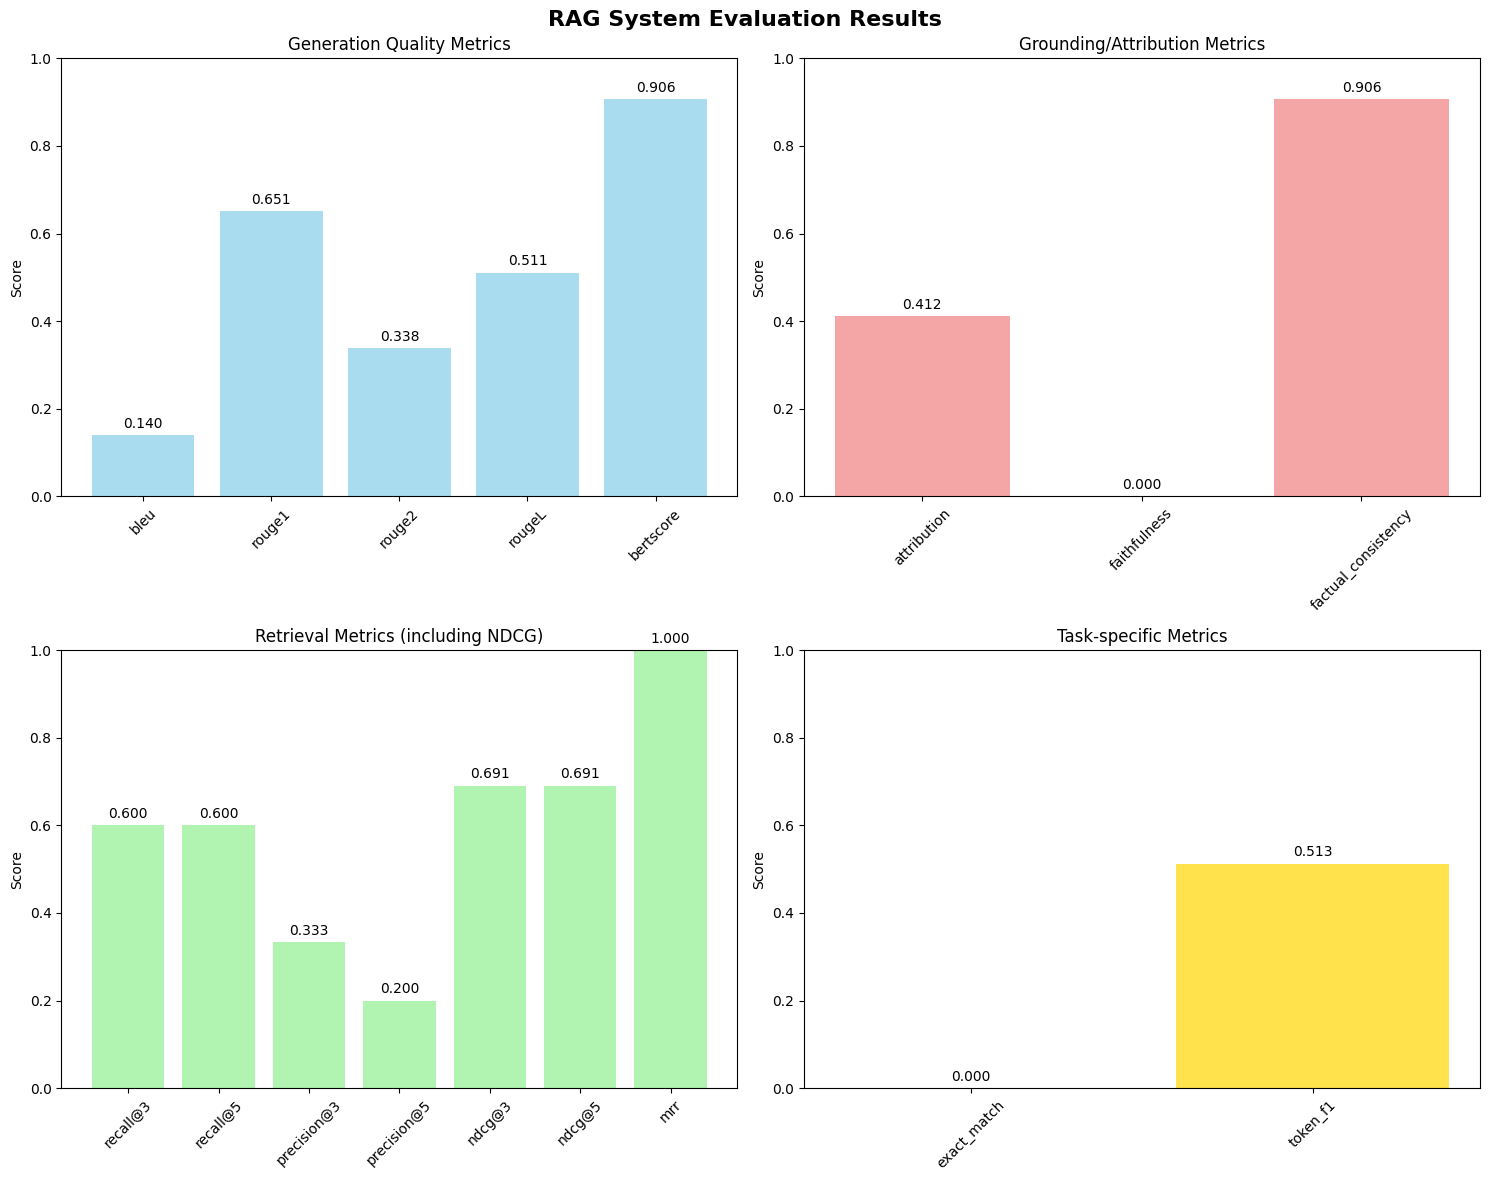


EVALUATION COMPLETE!
All metrics have been computed and displayed above.
NDCG@3 and NDCG@5 are included in the retrieval metrics section.


In [ ]:
import torch
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import re
from collections import Counter
import math
from typing import List, Dict, Tuple, Any
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

class RAGEvaluator:
    """
    Comprehensive RAG evaluation framework covering:
    1. Retrieval Metrics (Recall@K, nDCG, MRR)
    2. Grounding/Attribution Metrics (FActScore, Attribution)
    3. Generation Quality Metrics (BLEU, ROUGE, BERTScore)
    4. Task-specific Metrics (Exact Match, F1)
    """

    def __init__(self, embedding_model_name='all-MiniLM-L6-v2', device='cuda'):
        self.device = device if torch.cuda.is_available() else 'cpu'
        self.embedding_model = SentenceTransformer(embedding_model_name, device=self.device)

        # Initialize NLI model for attribution checking
        try:
            self.nli_pipeline = pipeline(
                "zero-shot-classification",
                model="facebook/bart-large-mnli",
                device=0 if self.device == 'cuda' else -1
            )
        except:
            print("Warning: NLI model not available. Attribution metrics will be limited.")
            self.nli_pipeline = None

        # Initialize ROUGE scorer
        self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

        print(f"RAG Evaluator initialized on {self.device}")

    # ========================================
    # RETRIEVAL METRICS
    # ========================================

    def recall_at_k(self, retrieved_docs: List[str], relevant_docs: List[str], k: int) -> float:
        """
        Recall@K: Fraction of relevant documents retrieved in top-k results
        """
        if not relevant_docs:
            return 0.0

        retrieved_set = set(retrieved_docs[:k])
        relevant_set = set(relevant_docs)

        intersection = len(retrieved_set.intersection(relevant_set))
        return intersection / len(relevant_set)

    def precision_at_k(self, retrieved_docs: List[str], relevant_docs: List[str], k: int) -> float:
        """
        Precision@K: Fraction of retrieved documents that are relevant
        """
        if k == 0:
            return 0.0

        retrieved_set = set(retrieved_docs[:k])
        relevant_set = set(relevant_docs)

        intersection = len(retrieved_set.intersection(relevant_set))
        return intersection / min(k, len(retrieved_docs))

    def ndcg_at_k(self, retrieved_docs: List[str], relevant_docs: List[str], k: int) -> float:
        """
        Normalized Discounted Cumulative Gain@K
        """
        if not relevant_docs:
            return 0.0

        # Create relevance scores (1 for relevant, 0 for irrelevant)
        relevance_scores = []
        for doc in retrieved_docs[:k]:
            relevance_scores.append(1 if doc in relevant_docs else 0)

        # Calculate DCG
        dcg = 0.0
        for i, score in enumerate(relevance_scores):
            dcg += score / math.log2(i + 2)  # i+2 because log2(1) = 0

        # Calculate IDCG (ideal DCG)
        ideal_scores = [1] * min(len(relevant_docs), k)
        idcg = 0.0
        for i, score in enumerate(ideal_scores):
            idcg += score / math.log2(i + 2)

        return dcg / idcg if idcg > 0 else 0.0

    def mean_reciprocal_rank(self, retrieved_docs: List[str], relevant_docs: List[str]) -> float:
        """
        Mean Reciprocal Rank: 1/rank of first relevant document
        """
        for i, doc in enumerate(retrieved_docs):
            if doc in relevant_docs:
                return 1.0 / (i + 1)
        return 0.0

    # ========================================
    # GROUNDING/ATTRIBUTION METRICS
    # ========================================

    def compute_attribution_score(self, generated_answer: str, retrieved_docs: List[str]) -> float:
        """
        Attribution Score: How well the generated answer is supported by retrieved documents
        Uses semantic similarity between answer and context
        """
        if not retrieved_docs or not generated_answer.strip():
            return 0.0

        # Embed the generated answer
        answer_embedding = self.embedding_model.encode([generated_answer])

        # Embed retrieved documents
        doc_embeddings = self.embedding_model.encode(retrieved_docs)

        # Calculate cosine similarities
        similarities = []
        for doc_emb in doc_embeddings:
            similarity = np.dot(answer_embedding[0], doc_emb) / (
                np.linalg.norm(answer_embedding[0]) * np.linalg.norm(doc_emb)
            )
            similarities.append(similarity)

        # Return maximum similarity (best attribution)
        return max(similarities) if similarities else 0.0

    def compute_faithfulness_score(self, generated_answer: str, retrieved_docs: List[str]) -> float:
        """
        Faithfulness: Whether the generated answer contains hallucinated information
        Based on NLI entailment between context and answer
        """
        if not self.nli_pipeline or not retrieved_docs or not generated_answer.strip():
            return 0.0

        try:
            context = " ".join(retrieved_docs)

            # Use NLI to check if context entails the generated answer
            result = self.nli_pipeline(generated_answer, [context])

            # Look for entailment score
            for label, score in zip(result['labels'], result['scores']):
                if 'entailment' in label.lower():
                    return score

            return 0.0
        except:
            return 0.0

    def compute_factual_consistency(self, generated_answer: str, ground_truth: str) -> float:
        """
        Factual Consistency: Semantic similarity between generated answer and ground truth
        """
        if not generated_answer.strip() or not ground_truth.strip():
            return 0.0

        embeddings = self.embedding_model.encode([generated_answer, ground_truth])
        similarity = np.dot(embeddings[0], embeddings[1]) / (
            np.linalg.norm(embeddings[0]) * np.linalg.norm(embeddings[1])
        )
        return similarity

    # ========================================
    # GENERATION QUALITY METRICS
    # ========================================

    def compute_bleu_score(self, generated_answer: str, reference_answers: List[str]) -> float:
        """
        BLEU Score: Precision-based metric measuring n-gram overlap
        """
        if not generated_answer.strip() or not reference_answers:
            return 0.0

        # Tokenize
        generated_tokens = nltk.word_tokenize(generated_answer.lower())
        reference_tokens = [nltk.word_tokenize(ref.lower()) for ref in reference_answers]

        # Calculate BLEU with smoothing
        smoothing = SmoothingFunction().method1
        try:
            return sentence_bleu(reference_tokens, generated_tokens, smoothing_function=smoothing)
        except:
            return 0.0

    def compute_rouge_scores(self, generated_answer: str, reference_answers: List[str]) -> Dict[str, float]:
        """
        ROUGE Scores: Recall-based metrics (ROUGE-1, ROUGE-2, ROUGE-L)
        """
        if not generated_answer.strip() or not reference_answers:
            return {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

        # Calculate ROUGE against all references and take the maximum
        max_scores = {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

        for reference in reference_answers:
            scores = self.rouge_scorer.score(reference, generated_answer)
            for metric in max_scores:
                max_scores[metric] = max(max_scores[metric], scores[metric].fmeasure)

        return max_scores

    def compute_bertscore(self, generated_answer: str, reference_answers: List[str]) -> float:
        """
        BERTScore: Semantic similarity using contextualized embeddings
        """
        if not generated_answer.strip() or not reference_answers:
            return 0.0

        # Use sentence transformers for semantic similarity
        all_texts = [generated_answer] + reference_answers
        embeddings = self.embedding_model.encode(all_texts)

        # Calculate similarity with each reference, return max
        gen_embedding = embeddings[0]
        similarities = []

        for i in range(1, len(embeddings)):
            ref_embedding = embeddings[i]
            similarity = np.dot(gen_embedding, ref_embedding) / (
                np.linalg.norm(gen_embedding) * np.linalg.norm(ref_embedding)
            )
            similarities.append(similarity)

        return max(similarities) if similarities else 0.0

    # ========================================
    # TASK-SPECIFIC METRICS
    # ========================================

    def exact_match(self, generated_answer: str, reference_answers: List[str]) -> float:
        """
        Exact Match: Binary metric for exact string match
        """
        if not generated_answer.strip() or not reference_answers:
            return 0.0

        generated_normalized = generated_answer.lower().strip()
        for reference in reference_answers:
            if generated_normalized == reference.lower().strip():
                return 1.0
        return 0.0

    def token_f1_score(self, generated_answer: str, reference_answers: List[str]) -> float:
        """
        Token-level F1 Score: F1 based on token overlap
        """
        if not generated_answer.strip() or not reference_answers:
            return 0.0

        generated_tokens = set(generated_answer.lower().split())

        max_f1 = 0.0
        for reference in reference_answers:
            reference_tokens = set(reference.lower().split())

            if len(reference_tokens) == 0 and len(generated_tokens) == 0:
                f1 = 1.0
            elif len(reference_tokens) == 0 or len(generated_tokens) == 0:
                f1 = 0.0
            else:
                intersection = generated_tokens.intersection(reference_tokens)
                precision = len(intersection) / len(generated_tokens)
                recall = len(intersection) / len(reference_tokens)
                f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

            max_f1 = max(max_f1, f1)

        return max_f1

    # ========================================
    # COMPREHENSIVE EVALUATION
    # ========================================

    def evaluate_rag_system(self,
                          queries: List[str],
                          retrieved_docs_list: List[List[str]],
                          generated_answers: List[str],
                          reference_answers_list: List[List[str]],
                          relevant_docs_list: List[List[str]] = None) -> Dict[str, Any]:
        """
        Comprehensive evaluation of a RAG system
        """

        results = {
            'retrieval_metrics': [],
            'generation_metrics': [],
            'grounding_metrics': [],
            'task_metrics': []
        }

        for i, (query, retrieved_docs, generated_answer, reference_answers) in enumerate(
            zip(queries, retrieved_docs_list, generated_answers, reference_answers_list)):

            # Retrieval Metrics (if relevant docs are provided)
            if relevant_docs_list and i < len(relevant_docs_list):
                relevant_docs = relevant_docs_list[i]
                retrieval_result = {
                    'query_idx': i,
                    'recall@3': self.recall_at_k(retrieved_docs, relevant_docs, 3),
                    'recall@5': self.recall_at_k(retrieved_docs, relevant_docs, 5),
                    'precision@3': self.precision_at_k(retrieved_docs, relevant_docs, 3),
                    'precision@5': self.precision_at_k(retrieved_docs, relevant_docs, 5),
                    'ndcg@3': self.ndcg_at_k(retrieved_docs, relevant_docs, 3),
                    'ndcg@5': self.ndcg_at_k(retrieved_docs, relevant_docs, 5),
                    'mrr': self.mean_reciprocal_rank(retrieved_docs, relevant_docs)
                }
                results['retrieval_metrics'].append(retrieval_result)

            # Generation Quality Metrics
            rouge_scores = self.compute_rouge_scores(generated_answer, reference_answers)
            generation_result = {
                'query_idx': i,
                'bleu': self.compute_bleu_score(generated_answer, reference_answers),
                'rouge1': rouge_scores['rouge1'],
                'rouge2': rouge_scores['rouge2'],
                'rougeL': rouge_scores['rougeL'],
                'bertscore': self.compute_bertscore(generated_answer, reference_answers)
            }
            results['generation_metrics'].append(generation_result)

            # Grounding/Attribution Metrics
            grounding_result = {
                'query_idx': i,
                'attribution': self.compute_attribution_score(generated_answer, retrieved_docs),
                'faithfulness': self.compute_faithfulness_score(generated_answer, retrieved_docs),
                'factual_consistency': self.compute_factual_consistency(generated_answer, reference_answers[0] if reference_answers else "")
            }
            results['grounding_metrics'].append(grounding_result)

            # Task-specific Metrics
            task_result = {
                'query_idx': i,
                'exact_match': self.exact_match(generated_answer, reference_answers),
                'token_f1': self.token_f1_score(generated_answer, reference_answers)
            }
            results['task_metrics'].append(task_result)

        return results

    def aggregate_results(self, evaluation_results: Dict[str, Any]) -> Dict[str, Dict[str, float]]:
        """
        Aggregate evaluation results across all queries
        Returns simplified structure for easier printing
        """
        aggregated = {}

        for metric_type, results_list in evaluation_results.items():
            if not results_list:
                continue

            aggregated[metric_type] = {}

            # Get all metric names (excluding query_idx)
            metric_names = [key for key in results_list[0].keys() if key != 'query_idx']

            for metric_name in metric_names:
                values = [result[metric_name] for result in results_list if result[metric_name] is not None]
                if values:  # Only compute if we have valid values
                    aggregated[metric_type][metric_name] = np.mean(values)
                else:
                    aggregated[metric_type][metric_name] = 0.0

        return aggregated

    def get_detailed_stats(self, evaluation_results: Dict[str, Any]) -> Dict[str, Dict[str, Dict[str, float]]]:
        """
        Get detailed statistics including mean, std, min, max for each metric
        """
        detailed_stats = {}

        for metric_type, results_list in evaluation_results.items():
            if not results_list:
                continue

            detailed_stats[metric_type] = {}

            # Get all metric names (excluding query_idx)
            metric_names = [key for key in results_list[0].keys() if key != 'query_idx']

            for metric_name in metric_names:
                values = [result[metric_name] for result in results_list if result[metric_name] is not None]
                if values:
                    detailed_stats[metric_type][metric_name] = {
                        'mean': np.mean(values),
                        'std': np.std(values),
                        'median': np.median(values),
                        'min': np.min(values),
                        'max': np.max(values),
                        'count': len(values)
                    }
                else:
                    detailed_stats[metric_type][metric_name] = {
                        'mean': 0.0, 'std': 0.0, 'median': 0.0,
                        'min': 0.0, 'max': 0.0, 'count': 0
                    }

        return detailed_stats

    def print_detailed_results(self, evaluation_results: Dict[str, Any]):
        """
        Print comprehensive results with all metrics properly displayed
        """
        print("\n" + "="*80)
        print("COMPREHENSIVE RAG EVALUATION RESULTS")
        print("="*80)

        detailed_stats = self.get_detailed_stats(evaluation_results)

        for metric_type, metrics in detailed_stats.items():
            if not metrics:
                continue

            print(f"\n{metric_type.upper().replace('_', ' ')}:")
            print("-" * 60)

            for metric_name, stats in metrics.items():
                if stats['count'] > 0:
                    print(f"  {metric_name:20}: {stats['mean']:.4f} ± {stats['std']:.4f} "
                          f"(min: {stats['min']:.4f}, max: {stats['max']:.4f})")
                else:
                    print(f"  {metric_name:20}: No valid data")

        # Print summary of best performing metrics
        print(f"\n{'SUMMARY OF TOP PERFORMING METRICS'}")
        print("-" * 60)

        all_metrics = []
        for metric_type, metrics in detailed_stats.items():
            for metric_name, stats in metrics.items():
                if stats['count'] > 0:
                    all_metrics.append((f"{metric_type}_{metric_name}", stats['mean']))

        # Sort by performance (highest first)
        all_metrics.sort(key=lambda x: x[1], reverse=True)

        print("Top 10 metrics by mean score:")
        for i, (metric_name, score) in enumerate(all_metrics[:10]):
            print(f"  {i+1:2d}. {metric_name:30}: {score:.4f}")

    def visualize_results(self, evaluation_results: Dict[str, Any], save_path: str = None):
        """
        Create comprehensive visualizations of evaluation results
        """
        # Calculate number of subplots needed
        metric_types = [k for k, v in evaluation_results.items() if v]
        n_plots = len(metric_types)

        if n_plots == 0:
            print("No metrics to visualize")
            return

        # Create subplots in a grid
        cols = 2
        rows = (n_plots + 1) // 2

        fig, axes = plt.subplots(rows, cols, figsize=(15, 6*rows))
        fig.suptitle('RAG System Evaluation Results', fontsize=16, fontweight='bold')

        # Flatten axes for easier indexing
        if n_plots == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]
        else:
            axes = axes.flatten()

        plot_idx = 0

        # 1. Generation Quality Metrics
        if evaluation_results.get('generation_metrics'):
            gen_df = pd.DataFrame(evaluation_results['generation_metrics'])
            gen_metrics = ['bleu', 'rouge1', 'rouge2', 'rougeL', 'bertscore']
            gen_means = [gen_df[metric].mean() for metric in gen_metrics if metric in gen_df.columns]
            valid_gen_metrics = [metric for metric in gen_metrics if metric in gen_df.columns]

            if valid_gen_metrics:
                axes[plot_idx].bar(valid_gen_metrics, gen_means, color='skyblue', alpha=0.7)
                axes[plot_idx].set_title('Generation Quality Metrics')
                axes[plot_idx].set_ylabel('Score')
                axes[plot_idx].tick_params(axis='x', rotation=45)
                axes[plot_idx].set_ylim(0, 1)

                # Add value labels on bars
                for i, v in enumerate(gen_means):
                    axes[plot_idx].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

                plot_idx += 1

        # 2. Grounding Metrics
        if evaluation_results.get('grounding_metrics'):
            ground_df = pd.DataFrame(evaluation_results['grounding_metrics'])
            ground_metrics = ['attribution', 'faithfulness', 'factual_consistency']
            ground_means = [ground_df[metric].mean() for metric in ground_metrics if metric in ground_df.columns]
            valid_ground_metrics = [metric for metric in ground_metrics if metric in ground_df.columns]

            if valid_ground_metrics:
                axes[plot_idx].bar(valid_ground_metrics, ground_means, color='lightcoral', alpha=0.7)
                axes[plot_idx].set_title('Grounding/Attribution Metrics')
                axes[plot_idx].set_ylabel('Score')
                axes[plot_idx].tick_params(axis='x', rotation=45)
                axes[plot_idx].set_ylim(0, 1)

                # Add value labels on bars
                for i, v in enumerate(ground_means):
                    axes[plot_idx].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

                plot_idx += 1

        # 3. Retrieval Metrics (if available)
        if evaluation_results.get('retrieval_metrics'):
            ret_df = pd.DataFrame(evaluation_results['retrieval_metrics'])
            ret_metrics = ['recall@3', 'recall@5', 'precision@3', 'precision@5', 'ndcg@3', 'ndcg@5', 'mrr']
            ret_means = [ret_df[metric].mean() for metric in ret_metrics if metric in ret_df.columns]
            valid_ret_metrics = [metric for metric in ret_metrics if metric in ret_df.columns]

            if valid_ret_metrics:
                axes[plot_idx].bar(valid_ret_metrics, ret_means, color='lightgreen', alpha=0.7)
                axes[plot_idx].set_title('Retrieval Metrics (including NDCG)')
                axes[plot_idx].set_ylabel('Score')
                axes[plot_idx].tick_params(axis='x', rotation=45)
                axes[plot_idx].set_ylim(0, 1)

                # Add value labels on bars
                for i, v in enumerate(ret_means):
                    axes[plot_idx].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

                plot_idx += 1

        # 4. Task-specific Metrics
        if evaluation_results.get('task_metrics'):
            task_df = pd.DataFrame(evaluation_results['task_metrics'])
            task_metrics = ['exact_match', 'token_f1']
            task_means = [task_df[metric].mean() for metric in task_metrics if metric in task_df.columns]
            valid_task_metrics = [metric for metric in task_metrics if metric in task_df.columns]

            if valid_task_metrics:
                axes[plot_idx].bar(valid_task_metrics, task_means, color='gold', alpha=0.7)
                axes[plot_idx].set_title('Task-specific Metrics')
                axes[plot_idx].set_ylabel('Score')
                axes[plot_idx].tick_params(axis='x', rotation=45)
                axes[plot_idx].set_ylim(0, 1)

                # Add value labels on bars
                for i, v in enumerate(task_means):
                    axes[plot_idx].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

                plot_idx += 1

        # Hide unused subplots
        for i in range(plot_idx, len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()


# ========================================
# EXAMPLE USAGE WITH YOUR RAG SYSTEM
# ========================================

def evaluate_your_rag_system(rag_evaluator, retrieve_context_func, generate_answer_func):
    """
    Example of how to integrate the evaluator with your existing RAG system
    """

    # Test queries (you can expand this)
    test_queries = [
        "Why is the sky blue?",
        "How do airplanes stay in the air?",
        "What is the capital of Washington State?",
        "How does photosynthesis work?",
        "What causes earthquakes?"
    ]

    # Ground truth answers (you would need to create these for your dataset)
    reference_answers = [
        ["The sky appears blue because of Rayleigh scattering. When sunlight enters Earth's atmosphere, it collides with gas molecules. Blue light has a shorter wavelength and gets scattered more than other colors."],
        ["Airplanes stay in the air due to lift generated by their wings. The wing shape and angle create different air pressures above and below the wing, with lower pressure on top creating upward lift."],
        ["The capital of Washington State is Olympia."],
        ["Photosynthesis is the process where plants use sunlight, carbon dioxide, and water to produce glucose and oxygen. Chlorophyll in plant cells captures light energy to drive this chemical reaction."],
        ["Earthquakes are caused by the sudden release of energy stored in Earth's crust. This typically occurs when tectonic plates move against each other along fault lines."]
    ]

    # Mock relevant docs for retrieval evaluation (you would need real relevance judgments)
    relevant_docs_list = [
        ["doc_sky_1", "doc_sky_2"],
        ["doc_airplane_1", "doc_airplane_2"],
        ["doc_washington_1"],
        ["doc_photosynthesis_1", "doc_photosynthesis_2"],
        ["doc_earthquake_1", "doc_earthquake_2"]
    ]

    # Collect results from your RAG system
    retrieved_docs_list = []
    generated_answers = []

    print("Running RAG evaluation...")
    for i, query in enumerate(test_queries):
        print(f"Processing query {i+1}/{len(test_queries)}: {query}")

        # Use your existing functions
        retrieved_docs = retrieve_context_func(query, top_k=5)
        generated_answer = generate_answer_func(query, retrieved_docs)

        retrieved_docs_list.append(retrieved_docs)
        generated_answers.append(generated_answer)

        print(f"  Generated: {generated_answer[:100]}...")
        print()

    # Run comprehensive evaluation
    print("Computing evaluation metrics...")
    results = rag_evaluator.evaluate_rag_system(
        queries=test_queries,
        retrieved_docs_list=retrieved_docs_list,
        generated_answers=generated_answers,
        reference_answers_list=reference_answers,
        relevant_docs_list=relevant_docs_list  # Include for retrieval metrics
    )

    # Display results with the new comprehensive method
    rag_evaluator.print_detailed_results(results)

    # Create visualizations
    rag_evaluator.visualize_results(results)

    return results


# ========================================
# MOCK FUNCTIONS FOR TESTING
# ========================================

def mock_retrieve_context(query: str, top_k: int = 5) -> List[str]:
    """Mock retrieval function for testing"""
    # This would be replaced with your actual retrieval function
    mock_docs = {
        "Why is the sky blue?": ["doc_sky_1", "doc_atmosphere_1", "doc_light_1", "doc_color_1", "doc_physics_1"],
        "How do airplanes stay in the air?": ["doc_airplane_1", "doc_aerodynamics_1", "doc_lift_1", "doc_wing_1", "doc_flight_1"],
        "What is the capital of Washington State?": ["doc_washington_1", "doc_olympia_1", "doc_states_1", "doc_geography_1", "doc_capitals_1"],
        "How does photosynthesis work?": ["doc_photosynthesis_1", "doc_plants_1", "doc_chlorophyll_1", "doc_biology_1", "doc_energy_1"],
        "What causes earthquakes?": ["doc_earthquake_1", "doc_tectonic_1", "doc_geology_1", "doc_fault_1", "doc_seismic_1"]
    }

    return mock_docs.get(query, ["doc_generic_1", "doc_generic_2", "doc_generic_3", "doc_generic_4", "doc_generic_5"])[:top_k]

def mock_generate_answer(query: str, retrieved_docs: List[str]) -> str:
    """Mock generation function for testing"""
    # This would be replaced with your actual generation function
    mock_answers = {
        "Why is the sky blue?": "The sky appears blue due to Rayleigh scattering, where shorter blue wavelengths are scattered more by atmospheric particles.",
        "How do airplanes stay in the air?": "Airplanes stay airborne through lift generated by wing shape and air pressure differences above and below the wings.",
        "What is the capital of Washington State?": "Olympia is the capital city of Washington State.",
        "How does photosynthesis work?": "Photosynthesis converts sunlight, water, and CO2 into glucose and oxygen using chlorophyll in plant cells.",
        "What causes earthquakes?": "Earthquakes result from sudden energy release when tectonic plates move along fault lines in Earth's crust."
    }

    return mock_answers.get(query, "I don't have enough information to answer this question accurately.")


# Initialize the evaluator
if __name__ == "__main__":
    print("Initializing RAG Evaluator...")
    evaluator = RAGEvaluator()

    print("\nRAG Evaluator ready!")
    print("Available metrics:")
    print("  Retrieval: Recall@K, Precision@K, nDCG@K, MRR")
    print("  Generation: BLEU, ROUGE (1,2,L), BERTScore")
    print("  Grounding: Attribution, Faithfulness, Factual Consistency")
    print("  Task-specific: Exact Match, Token F1")
    print("\nTo use with your RAG system, call:")
    print("  evaluate_your_rag_system(evaluator, retrieve_context, generate_answer)")

    # Example usage with mock functions
    print("\n" + "="*60)
    print("RUNNING EXAMPLE EVALUATION WITH MOCK DATA")
    print("="*60)

    # Run evaluation with mock functions to demonstrate all metrics
    results = evaluate_your_rag_system(evaluator, mock_retrieve_context, mock_generate_answer)

    print(f"\n{'EVALUATION COMPLETE!'}")
    print("="*60)
    print("All metrics have been computed and displayed above.")
    print("NDCG@3 and NDCG@5 are included in the retrieval metrics section.")

In [ ]:
"""
Simplified RAG Evaluation Framework
====================================
Evaluates RAG system using:
1. RAGAS on ground truth (top comment)
2. RAGAS on generated response
3. LLM-as-Judge on ground truth
4. LLM-as-Judge on generated response

Uses first 300 questions from ELI5 dataset
"""

import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy
from ragas.run_config import RunConfig
from openai import OpenAI
import json
import time
import os
from getpass import getpass

# Initialize OpenAI client
client = None

# ============================================================================
# STEP 1: LOAD FIRST 300 QUESTIONS FROM ELI5
# ============================================================================

def load_eli5_questions(num_questions=300):
    """
    Load first 300 questions from ELI5 dataset
    """
    print("🔄 Loading ELI5 dataset...")
    dataset = load_dataset("kilt_tasks", "eli5", split=f"train[:{num_questions}]")

    # Create list to store questions with metadata
    all_questions = []

    for idx, example in enumerate(dataset):
        question = example['input'].strip()
        all_questions.append({
            'question': question,
            'eli5_index': idx,
            'category': f'batch_{idx // 50}',  # Simple category grouping
            'source': 'eli5'
        })

    print(f"✅ Loaded {len(all_questions)} questions from ELI5")

    return all_questions, dataset

# ============================================================================
# STEP 2: LLM-AS-JUDGE IMPLEMENTATION
# ============================================================================

def llm_judge_faithfulness(question, contexts, answer, model="gpt-4"):
    """
    LLM-as-Judge for faithfulness evaluation
    """
    global client
    if client is None:
        client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

    context_str = "\n\n".join(contexts) if isinstance(contexts, list) else contexts

    prompt = f"""You are an expert evaluator assessing whether a generated answer is faithful to retrieved context.

**IMPORTANT GUIDELINES**:
1. Accept paraphrasing - exact wording is NOT required
2. Penalize tautologies (just repeating the question)
3. Penalize over-compressed answers (too brief to be useful)
4. Reward substantive, well-grounded explanations

**Question**: {question}

**Retrieved Context**:
{context_str}

**Generated Answer**: {answer}

**Evaluation Steps**:
1. Check if answer is just a tautology (repeating question without explanation)
2. Check if answer is substantive (provides actual information, not 1-2 words)
3. Identify claims in the answer
4. Verify each claim against context (accept paraphrasing)
5. Assign score based on criteria below

**Scoring Criteria**:
- 0.0: Tautology or provides no information
- 0.1-0.3: Over-compressed (too brief) or mostly unsupported
- 0.4-0.6: Partially grounded, missing key information
- 0.7-0.9: Well-grounded with minor gaps
- 1.0: Fully grounded, substantive explanation

**Respond in JSON format**:
{{
    "faithfulness_score": <float 0-1>,
    "is_tautology": <boolean>,
    "is_substantive": <boolean>,
    "supported_claims": ["claim1", "claim2"],
    "unsupported_claims": ["claim1"],
    "reasoning": "detailed explanation"
}}

Think step-by-step, then provide JSON response:"""

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a precise evaluator. Always respond with valid JSON."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.1,
            max_tokens=800
        )

        content = response.choices[0].message.content.strip()

        # Extract JSON from markdown if present
        if "```json" in content:
            content = content.split("```json")[1].split("```")[0].strip()
        elif "```" in content:
            content = content.split("```")[1].split("```")[0].strip()

        result = json.loads(content)

        return {
            'faithfulness_score': result.get('faithfulness_score', 0.0),
            'is_tautology': result.get('is_tautology', False),
            'is_substantive': result.get('is_substantive', True),
            'reasoning': result.get('reasoning', ''),
            'supported_claims': result.get('supported_claims', []),
            'unsupported_claims': result.get('unsupported_claims', [])
        }

    except Exception as e:
        print(f"❌ LLM Judge Error: {e}")
        return {
            'faithfulness_score': 0.0,
            'is_tautology': False,
            'is_substantive': False,
            'reasoning': f'Error: {str(e)}',
            'supported_claims': [],
            'unsupported_claims': []
        }

def llm_judge_answer_relevancy(question, answer, model="gpt-4"):
    """
    LLM-as-Judge for answer relevancy
    """
    global client
    if client is None:
        client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

    prompt = f"""Evaluate if this answer directly addresses the question asked.

**Question**: {question}

**Answer**: {answer}

**Scoring**:
- 1.0: Directly answers the question
- 0.7-0.9: Mostly relevant with minor tangents
- 0.4-0.6: Partially relevant
- 0.1-0.3: Barely relevant
- 0.0: Off-topic or tautology

Respond in JSON:
{{
    "relevancy_score": <float 0-1>,
    "reasoning": "explanation"
}}"""

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a precise evaluator. Always respond with valid JSON."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.1,
            max_tokens=300
        )

        content = response.choices[0].message.content.strip()
        if "```json" in content:
            content = content.split("```json")[1].split("```")[0].strip()
        elif "```" in content:
            content = content.split("```")[1].split("```")[0].strip()

        result = json.loads(content)

        return {
            'relevancy_score': result.get('relevancy_score', 0.0),
            'reasoning': result.get('reasoning', '')
        }

    except Exception as e:
        print(f"❌ LLM Judge Error: {e}")
        return {'relevancy_score': 0.0, 'reasoning': f'Error: {str(e)}'}

# ============================================================================
# STEP 3: EVALUATION PIPELINE
# ============================================================================

def evaluate_single_question(question_data, dataset, user_retrieve_func, user_generate_func):
    """
    Evaluate a single question with retrieval and generation
    """
    question = question_data['question']

    # Get ground truth (top comment from ELI5)
    eli5_example = dataset[question_data['eli5_index']]
    answers = eli5_example['output']
    if answers and len(answers) > 0:
        ground_truth = answers[0]['answer']  # Top comment
    else:
        ground_truth = "No ground truth available"

    # Retrieve contexts using YOUR function
    retrieved_contexts = user_retrieve_func(question, top_k=3)

    # Generate RAG answer using YOUR function
    rag_answer = user_generate_func(question, retrieved_contexts)

    results = {
        'question': question,
        'category': question_data['category'],
        'source': question_data['source'],
        'retrieved_contexts': retrieved_contexts,
        'ground_truth': ground_truth,
        'rag_answer': rag_answer
    }

    return results

def run_ragas_evaluation(data_dict):
    """
    Run RAGAS evaluation (faithfulness + answer_relevancy)
    """
    try:
        dataset = Dataset.from_dict({
            'question': [data_dict['question']],
            'contexts': [data_dict['retrieved_contexts']],
            'answer': [data_dict['answer']],
            'ground_truth': [data_dict['ground_truth']]
        })

        run_config = RunConfig(timeout=120, max_workers=1, max_wait=180)

        results = evaluate(
            dataset,
            metrics=[faithfulness, answer_relevancy],
            run_config=run_config
        )

        df = results.to_pandas()

        return {
            'ragas_faithfulness': float(df['faithfulness'].iloc[0]) if 'faithfulness' in df.columns else 0.0,
            'ragas_answer_relevancy': float(df['answer_relevancy'].iloc[0]) if 'answer_relevancy' in df.columns else 0.0
        }
    except Exception as e:
        print(f"❌ RAGAS Error: {e}")
        return {
            'ragas_faithfulness': 0.0,
            'ragas_answer_relevancy': 0.0
        }

def comprehensive_evaluation(questions_data, dataset, user_retrieve_func, user_generate_func,
                            save_checkpoint_every=50):
    """
    Run all 4 evaluations on all questions with checkpoint saving
    """
    all_results = []
    checkpoint_file = 'evaluation_checkpoint.csv'

    # Load existing checkpoint if available
    start_idx = 0
    if os.path.exists(checkpoint_file):
        print(f"📂 Found checkpoint file. Loading previous results...")
        checkpoint_df = pd.read_csv(checkpoint_file)
        all_results = checkpoint_df.to_dict('records')
        start_idx = len(all_results)
        print(f"✅ Resuming from question {start_idx + 1}")

    print(f"\n{'='*80}")
    print(f"🚀 COMPREHENSIVE EVALUATION: {len(questions_data)} QUESTIONS")
    print(f"{'='*80}\n")

    for idx in range(start_idx, len(questions_data)):
        q_data = questions_data[idx]
        print(f"\n[{idx+1}/{len(questions_data)}] {q_data['question'][:60]}...")

        try:
            # Get basic results (retrieve + generate)
            results = evaluate_single_question(q_data, dataset, user_retrieve_func, user_generate_func)

            # 1. RAGAS on Ground Truth
            print("  ├─ Running RAGAS on ground truth...")
            ragas_gt = run_ragas_evaluation({
                'question': results['question'],
                'retrieved_contexts': results['retrieved_contexts'],
                'answer': results['ground_truth'],
                'ground_truth': results['ground_truth']
            })

            # 2. RAGAS on RAG Answer
            print("  ├─ Running RAGAS on RAG answer...")
            ragas_rag = run_ragas_evaluation({
                'question': results['question'],
                'retrieved_contexts': results['retrieved_contexts'],
                'answer': results['rag_answer'],
                'ground_truth': results['ground_truth']
            })

            # 3. LLM Judge on Ground Truth
            print("  ├─ Running LLM Judge on ground truth...")
            llm_gt_faith = llm_judge_faithfulness(
                results['question'],
                results['retrieved_contexts'],
                results['ground_truth']
            )
            llm_gt_rel = llm_judge_answer_relevancy(
                results['question'],
                results['ground_truth']
            )

            # 4. LLM Judge on RAG Answer
            print("  └─ Running LLM Judge on RAG answer...")
            llm_rag_faith = llm_judge_faithfulness(
                results['question'],
                results['retrieved_contexts'],
                results['rag_answer']
            )
            llm_rag_rel = llm_judge_answer_relevancy(
                results['question'],
                results['rag_answer']
            )

            # Compile all results
            full_results = {
                **results,
                'retrieved_contexts_str': ' | '.join(results['retrieved_contexts'][:100] if isinstance(results['retrieved_contexts'], list) else [str(results['retrieved_contexts'])[:100]]),

                # RAGAS Ground Truth
                'ragas_gt_faithfulness': ragas_gt['ragas_faithfulness'],
                'ragas_gt_relevancy': ragas_gt['ragas_answer_relevancy'],

                # RAGAS RAG Answer
                'ragas_rag_faithfulness': ragas_rag['ragas_faithfulness'],
                'ragas_rag_relevancy': ragas_rag['ragas_answer_relevancy'],

                # LLM Judge Ground Truth
                'llm_gt_faithfulness': llm_gt_faith['faithfulness_score'],
                'llm_gt_relevancy': llm_gt_rel['relevancy_score'],
                'llm_gt_is_tautology': llm_gt_faith['is_tautology'],
                'llm_gt_is_substantive': llm_gt_faith['is_substantive'],
                'llm_gt_reasoning': llm_gt_faith['reasoning'],

                # LLM Judge RAG Answer
                'llm_rag_faithfulness': llm_rag_faith['faithfulness_score'],
                'llm_rag_relevancy': llm_rag_rel['relevancy_score'],
                'llm_rag_is_tautology': llm_rag_faith['is_tautology'],
                'llm_rag_is_substantive': llm_rag_faith['is_substantive'],
                'llm_rag_reasoning': llm_rag_faith['reasoning']
            }

            # Remove the full contexts list to avoid serialization issues
            del full_results['retrieved_contexts']

            all_results.append(full_results)

            # Save checkpoint periodically
            if (idx + 1) % save_checkpoint_every == 0:
                pd.DataFrame(all_results).to_csv(checkpoint_file, index=False)
                print(f"\n💾 Checkpoint saved at question {idx + 1}")

            # Rate limiting
            time.sleep(1)

        except Exception as e:
            print(f"❌ Error processing question {idx + 1}: {e}")
            import traceback
            traceback.print_exc()
            continue

    # Final save
    final_df = pd.DataFrame(all_results)
    final_df.to_csv(checkpoint_file, index=False)

    return final_df

# ============================================================================
# STEP 4: ANALYSIS AND REPORTING
# ============================================================================

def analyze_results(df):
    """
    Comprehensive analysis of all 4 evaluation methods
    """
    print(f"\n{'='*80}")
    print("📊 COMPREHENSIVE EVALUATION RESULTS")
    print(f"{'='*80}\n")

    # Overall statistics
    print("📈 OVERALL STATISTICS")
    print("-" * 80)

    metrics = [
        ('RAGAS Ground Truth Faithfulness', 'ragas_gt_faithfulness'),
        ('RAGAS Ground Truth Relevancy', 'ragas_gt_relevancy'),
        ('RAGAS RAG Faithfulness', 'ragas_rag_faithfulness'),
        ('RAGAS RAG Relevancy', 'ragas_rag_relevancy'),
        ('LLM Judge GT Faithfulness', 'llm_gt_faithfulness'),
        ('LLM Judge GT Relevancy', 'llm_gt_relevancy'),
        ('LLM Judge RAG Faithfulness', 'llm_rag_faithfulness'),
        ('LLM Judge RAG Relevancy', 'llm_rag_relevancy')
    ]

    for name, col in metrics:
        if col in df.columns:
            print(f"\n{name}:")
            print(f"  Mean:   {df[col].mean():.4f}")
            print(f"  Median: {df[col].median():.4f}")
            print(f"  Std:    {df[col].std():.4f}")
            print(f"  Min:    {df[col].min():.4f}")
            print(f"  Max:    {df[col].max():.4f}")

    # Category breakdown
    print(f"\n\n📊 PERFORMANCE BY CATEGORY")
    print("-" * 80)

    for category in df['category'].unique():
        cat_df = df[df['category'] == category]
        print(f"\n{category.upper()}:")
        print(f"  RAGAS RAG Faith:     {cat_df['ragas_rag_faithfulness'].mean():.4f}")
        print(f"  LLM Judge RAG Faith: {cat_df['llm_rag_faithfulness'].mean():.4f}")
        print(f"  RAGAS RAG Rel:       {cat_df['ragas_rag_relevancy'].mean():.4f}")
        print(f"  LLM Judge RAG Rel:   {cat_df['llm_rag_relevancy'].mean():.4f}")

    # Error pattern analysis
    print(f"\n\n🔍 ERROR PATTERN ANALYSIS")
    print("-" * 80)

    tautologies = df['llm_rag_is_tautology'].sum()
    not_substantive = (~df['llm_rag_is_substantive']).sum()

    print(f"Tautologies detected: {tautologies} ({tautologies/len(df)*100:.1f}%)")
    print(f"Non-substantive answers: {not_substantive} ({not_substantive/len(df)*100:.1f}%)")

    # Comparison: RAGAS vs LLM Judge
    print(f"\n\n⚖️  RAGAS vs LLM-JUDGE COMPARISON")
    print("-" * 80)

    faith_diff = (df['llm_rag_faithfulness'] - df['ragas_rag_faithfulness']).mean()
    rel_diff = (df['llm_rag_relevancy'] - df['ragas_rag_relevancy']).mean()

    print(f"Faithfulness Score Difference (LLM - RAGAS): {faith_diff:+.4f}")
    print(f"Relevancy Score Difference (LLM - RAGAS): {rel_diff:+.4f}")

    # Find disagreements
    large_disagreements = df[abs(df['llm_rag_faithfulness'] - df['ragas_rag_faithfulness']) > 0.5]
    print(f"\nLarge disagreements (>0.5 diff): {len(large_disagreements)}")

    return df

# ============================================================================
# MAIN EXECUTION FUNCTION
# ============================================================================

def run_comprehensive_evaluation_300q(user_retrieve_func, user_generate_func,
                                     num_questions=300):
    """
    Main function to run the complete evaluation

    Args:
        user_retrieve_func: YOUR retrieve_context function
        user_generate_func: YOUR generate_answer function
        num_questions: Number of questions from ELI5 (default 300)
    """
    print("="*80)
    print("COMPREHENSIVE RAG EVALUATION SYSTEM - ELI5 QUESTIONS")
    print("="*80)

    # Step 1: Load first N questions from ELI5
    questions_data, eli5_dataset = load_eli5_questions(num_questions=num_questions)

    # Step 2: Run comprehensive evaluation
    results_df = comprehensive_evaluation(
        questions_data,
        eli5_dataset,
        user_retrieve_func,
        user_generate_func
    )

    # Step 3: Analyze results
    analyzed_df = analyze_results(results_df)

    # Step 4: Save final results
    results_df.to_csv('comprehensive_rag_evaluation_300q.csv', index=False)
    print(f"\n✅ Final results saved to 'comprehensive_rag_evaluation_300q.csv'")

    # Step 5: Generate comparison plots
    try:
        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Plot 1: RAGAS vs LLM Judge - Faithfulness
        axes[0, 0].scatter(results_df['ragas_rag_faithfulness'],
                           results_df['llm_rag_faithfulness'], alpha=0.5)
        axes[0, 0].plot([0, 1], [0, 1], 'r--')
        axes[0, 0].set_xlabel('RAGAS Faithfulness')
        axes[0, 0].set_ylabel('LLM Judge Faithfulness')
        axes[0, 0].set_title('RAGAS vs LLM Judge: Faithfulness')

        # Plot 2: RAGAS vs LLM Judge - Relevancy
        axes[0, 1].scatter(results_df['ragas_rag_relevancy'],
                           results_df['llm_rag_relevancy'], alpha=0.5)
        axes[0, 1].plot([0, 1], [0, 1], 'r--')
        axes[0, 1].set_xlabel('RAGAS Relevancy')
        axes[0, 1].set_ylabel('LLM Judge Relevancy')
        axes[0, 1].set_title('RAGAS vs LLM Judge: Relevancy')

        # Plot 3: Category comparison
        category_means = results_df.groupby('category').agg({
            'ragas_rag_faithfulness': 'mean',
            'llm_rag_faithfulness': 'mean'
        })
        category_means.plot(kind='bar', ax=axes[1, 0])
        axes[1, 0].set_title('Faithfulness by Category')
        axes[1, 0].set_ylabel('Score')
        axes[1, 0].legend(['RAGAS', 'LLM Judge'])
        axes[1, 0].tick_params(axis='x', rotation=45)

        # Plot 4: Distribution comparison
        axes[1, 1].hist(results_df['ragas_rag_faithfulness'], alpha=0.5,
                        bins=20, label='RAGAS')
        axes[1, 1].hist(results_df['llm_rag_faithfulness'], alpha=0.5,
                        bins=20, label='LLM Judge')
        axes[1, 1].set_xlabel('Faithfulness Score')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Faithfulness Score Distribution')
        axes[1, 1].legend()

        plt.tight_layout()
        plt.savefig('rag_evaluation_comparison_300q.png', dpi=300, bbox_inches='tight')
        print(f"✅ Plots saved to 'rag_evaluation_comparison_300q.png'")
    except Exception as e:
        print(f"⚠️  Could not generate plots: {e}")

    print("\n" + "="*80)
    print("✅ EVALUATION COMPLETE!")
    print("="*80)

    return results_df


# ============================================================================
# USAGE INSTRUCTIONS & MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":

    print(f"\n{'='*80}")
    print("🔑 CHECKING OPENAI API KEY")
    print(f"{'='*80}")

    # Check for OpenAI API key
    if "OPENAI_API_KEY" not in os.environ:
        print("\n⚠️  OpenAI API key not found!")
        print("\nOptions:")
        print("1. Set in code: os.environ['OPENAI_API_KEY'] = 'sk-...'")
        print("2. Set in environment before running")
        print("3. Enter now:")

        api_key = getpass("Enter OpenAI API key (or press Enter to skip): ")
        if api_key.strip():
            os.environ["OPENAI_API_KEY"] = api_key.strip()
            print("✅ API key set!")
        else:
            print("❌ Cannot proceed without API key")
            print("\nGet your API key at: https://platform.openai.com/api-keys")
            exit(1)
    else:
        print("✅ OpenAI API key found!")

    # Check if RAG functions exist
    try:
        retrieve_context
        generate_answer
        print("✅ RAG functions detected!")
    except NameError:
        print("\n❌ RAG functions not found!")
        print("\nPlease ensure these functions are defined:")
        print("  - retrieve_context(question, top_k)")
        print("  - generate_answer(question, contexts)")
        print("\nRun your RAG implementation first, then run this evaluation.")
        exit(1)

    # Run evaluation
    results_df = run_comprehensive_evaluation_300q(
        user_retrieve_func=retrieve_context,  # YOUR retrieve_context function
        user_generate_func=generate_answer,    # YOUR generate_answer function
        num_questions=300
    )


🔑 CHECKING OPENAI API KEY
✅ OpenAI API key found!
✅ RAG functions detected!
COMPREHENSIVE RAG EVALUATION SYSTEM - ELI5 QUESTIONS
🔄 Loading ELI5 dataset...
✅ Loaded 300 questions from ELI5

🚀 COMPREHENSIVE EVALUATION: 300 QUESTIONS


[1/300] in football whats the point of wasting the first two plays w...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[2/300] Why are different tiers (regular < mid < premium) of gas' pr...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[3/300] Stars and Visibility...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[4/300] How do we know all the money the government is getting from ...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[5/300] What are good and bad sides of manual and automatic drive ge...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[6/300] the special and general theory of relativity...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[7/300] How do muscles grow?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[8/300] What is the role of actual real-life actors in making animat...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[9/300] Why does the water from my kitchen faucet taste different th...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[10/300] Precipitation reactions...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[11/300] If dark colours absorb more heat, why does light skin burn e...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[12/300] How the fuck does Facebook know about people I know?!...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[13/300] Why is chickenpox worse as an adult?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[14/300] How do movies not get uploaded online in HD from movie theat...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[15/300] Can defense attorneys 'throw' a case if they know their clie...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[16/300] why, when intoxicated, does it feel like everything is spinn...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[17/300] Why are some fish bones edible, and others are not?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[18/300] What's the meaning of the phrase "I've got a bone to pick wi...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[19/300] What is different in the brain chemistry that distinguishes ...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[20/300] Why can't we just taste candy or Sweets and then spit it out...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[21/300] Why are the things that taste the best bad for us?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[22/300] Why do you see weird colors when you press your eyes?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[23/300] If a movie production has $5,000,000 (estimated) Budget, mus...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[24/300] What classifies an island as an island? Aren't all continent...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[25/300] why does wikipedia ask for donations almost every month? do ...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[26/300] How does a water purifier jug work and could you put 3rd wor...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[27/300] Why people like getting drunk/sloshed/hammered/shit-faced ?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[28/300] What happens when a "too-big-to-fail" bank goes bankrupt....
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[29/300] Why is the recent Apple vs. FBI encryption debate relevant y...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[30/300] Why has the Mars Rover Opportunity's Lithium Ion Battery Las...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[31/300] Why some bugs fly to lights....
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[32/300] Why is sales tax in the US excluded from the list price?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[33/300] Why does a beer on tap almost always taste better than it do...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[34/300] What is the significance of Jamaican Bobsled team qualifies ...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[35/300] Is it possible to build up an immunity to poisons both natur...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[36/300] How do devices know the amount of charge left in a battery?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[37/300] Why are my muscles sore after jumping in cold water?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[38/300] why do we like watching the same TV show or movie over and o...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[39/300] why do the French have an abstain vote instead of people phy...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[40/300] Why The Beatles broke up?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[41/300] - Why do phones not require cooling vents but other small ap...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[42/300] Why are oil prices so shockingly low?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[43/300] If the inside of my microwave is made of metal, why is it ba...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[44/300] Why do we lack the instincts our ancestors had, e.g. telling...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[45/300] Why do we wake up early when we don't have to but tend to wa...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[46/300] Why do tech/software companies stay in the US when they are ...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[47/300] with such an important vote like appointing a supreme court ...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[48/300] If you put tires on your car that are larger than the ones f...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[49/300] How does bugspray kills bugs?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[50/300] The FairTax plan...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

💾 Checkpoint saved at question 50

[51/300] What is slowing down our internet speeds?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[52/300] If a computer has a GPU, why would reducing GUI effects impa...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[53/300] What happens if you don't pay your US Federal income tax?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[54/300] Why does my employer require a voided personal check in orde...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[55/300] Why are the insides of Ovens Dark and Not Metallic or Mirror...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[56/300] Why does metal react so violently when microwaved?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[57/300] Derivatives (in financial markets) and how people make money...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[58/300] How did the American accent come about?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[59/300] Why do The Miranda Rights state that anything you say can "a...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[60/300] Why is it when you rewind VHS tapes they lose their quality ...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[61/300] When a new library is built, where do they get their books? ...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[62/300] What was the Beat Generation about? Were Beatniks a stereoty...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[63/300] If the ozone layer is made up of O3, why are we not producin...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[64/300] What is Gene therapy?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[65/300] Is it possible to be a 'man without a country'?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[66/300] How do the grooves on a record/LP actually recreate the soun...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[67/300] In the English language, how are contractions prioritized wh...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Request too large for gpt-4 in organization org-SuMxHNAQI8jgWv3Fcr8iIiig on tokens per min (TPM): Limit 10000, Requested 10061. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
  └─ Running LLM Judge on RAG answer...
❌ LLM Judge Error: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens. However, your messages resulted in 9490 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}

[68/300] Eating things from other planets or moons....
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[69/300] The Cuban Missle Crisis and Americas enormous beef with Cuba...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[70/300] How do you build a Nanorobot..?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[71/300] Why doesn't it rain salt water?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[72/300] Why can't we use a centrifuge to de-salinate ocean water?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[73/300] Why do most viral videos now have licensing info in the desc...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[74/300] What is a MAC Address?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[75/300] How are adept music players able to just start playing along...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[76/300] Why drill instructor in the army never stop screaming at rec...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[77/300] if i ground up a piece of pure iron and ate it, would my bod...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[78/300] Whats is the actual cause of the common itch. and why is scr...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[79/300] When popcorn is popping, what is actually happening to the k...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[80/300] What happens to your brain when you space out?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[81/300] What is the point of a Kroger's Shopper card?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[82/300] What is a floating neutral and why is it damaging to applian...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[83/300] Why haven't our bodies changed to make childbirth less painf...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[84/300] American TV shows compared to The rest of the world....
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[85/300] How do people add colour so accurately to black and white ph...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[86/300] How do service animals help autistic children?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[87/300] Why do books downloaded from the library need to be "returne...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[88/300] How does Stephen Hawking's speech computer work?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[89/300] If a self-driving car detects multiple courses of action (al...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[90/300] why does spicy food make me sweat?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[91/300] If there are no size regulations regarding goalies in the NH...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[92/300] If animals aren't aware that they are going to die, why woul...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[93/300] How can a computer come up with a "random" number?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[94/300] Why are scars near impossible to get rid of?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[95/300] Why don't developed countries make their own clothing withou...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[96/300] Two spaceships are travelling towards each other at speed of...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[97/300] Why can we eat sushi raw but not other meats?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[98/300] Why is it when oil prices go up gas prices immediately go up...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
❌ LLM Judge Error: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens. However, your messages resulted in 8219 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
  └─ Running LLM Judge on RAG answer...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4 in organization org-SuMxHNAQI8jgWv3Fcr8iIiig on tokens per min (TPM): Limit 10000, Used 1189, Requested 8814. Please try again in 18ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

[99/300] How does a linear induction motor work?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[100/300] Does time ever end, or is the future infinite?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

💾 Checkpoint saved at question 100

[101/300] Why "crazy people" have that distinctive look to their eyes...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[102/300] The NASA twin study. I know what it is. Just explain their f...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[103/300] What is the point of money?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[104/300] Why does charge build up in a cloud?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[105/300] the hypothetical turtle on an island in the sun question?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[106/300] how does a home equity loan work?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[107/300] In English, what is the rule for the use of “An” or “A”...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[108/300] Why do we have two small nostrils and not one larger nostril...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[109/300] Border Gateway Protocol (BGP)...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: RateLimitError(Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}})


  ├─ Running LLM Judge on ground truth...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
  └─ Running LLM Judge on RAG answer...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'typ

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: RateLimitError(Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}})


  ├─ Running LLM Judge on ground truth...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
  └─ Running LLM Judge on RAG answer...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'typ

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[112/300] How do film/tv productions handle deaths of actors? Examples...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[113/300] Does the Sound Increase in Real Life when Someone on Televis...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[114/300] What would happen if all the countries wiped all the debt in...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[115/300] How is complimenting a woman on the street considered street...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[116/300] What is fake meat made of and how do they get the texture to...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[117/300] Why is it sometimes hard to find something that is right in ...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[118/300] Why doesn't the body produce oil like the face does?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[119/300] Dash cameras in Asia?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[120/300] Why do some people get brain freeze?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[121/300] Why is second day chili better?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[122/300] How does the _URL_0_ door knocking audio clip do such a good...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[123/300] Computer/TV Screen Size Pricing...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[124/300] If you have no sense of taste can you feel the heat/spicines...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[125/300] Why can we only use ~0.35 volts of batteries?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[126/300] Why do people think Yellowstone will explode and destroy the...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
❌ LLM Judge Error: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens. However, you requested 8372 tokens (7572 in the messages, 800 in the completion). Please reduce the length of the messages or completion.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
  └─ Running LLM Judge on RAG answer...
❌ LLM Judge Error: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens. However, you requested 8270 tokens (7470 in the messages, 800 in the completion). Please reduce the length of the messages or completion.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}

[127/300] How does cutting down trees to plant other vegetation for th...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[128/300] Mattress Sizes?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[129/300] What happens to Lactose when ingested by Lactose-Intolerants...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[130/300] If Helicopters need tail rotors to stabilize themselves from...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[131/300] What is the difference between an air-conditioner and a "mar...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[132/300] Why do people bother keeping savings in banks/currencies whi...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[133/300] Why does water freeze from top to bottom? Deep in the ocean ...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[134/300] how they catch digital pirates who use hotspots or do they?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[135/300] The voting rights of citizens in the District of Columbia hi...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[136/300] Why did it take so long to invent the printing press?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[137/300] I've been reading up on nukes. Did the Nevada nuclear tests ...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[138/300] How come cars are able to go up to 220 km/h but highways onl...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[139/300] Is it ever possible in the future to have matching finger/th...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[140/300] How a military can overthrow a government?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[141/300] How do we go from binary codes to basic programming language...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[142/300] why does spicy food stay spicy when it comes out the other e...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[143/300] Why do posts on reddit not start on 0 (what's the purpose of...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[144/300] if you light a lighter in front of a TV, why does the reflec...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[145/300] How does copyright work with references?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[146/300] Why does China take claim to Taiwan?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[147/300] Why is the word 'cunt' such a taboo word in the U.S.?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[148/300] why is it so easy for people to start working out regularly ...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[149/300] Why is the USA drinking age set at 21 when in most other res...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[150/300] Why do I not smell perfume I've sprayed on me but other peop...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

💾 Checkpoint saved at question 150

[151/300] How does a two headed reptile/siamese twins work? How do the...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[152/300] How do human voices work? What makes our voices seem so uniq...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[153/300] why aren't AK47's an "accurate" rifle...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

  ├─ Running LLM Judge on ground truth...
  └─ Running LLM Judge on RAG answer...

[154/300] Why can I not remember what happens when I'm drunk?...
  ├─ Running RAGAS on ground truth...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[1]: RateLimitError(Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}})


  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running LLM Judge on ground truth...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
  └─ Running LLM Judge on RAG answer...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}

[155/300] Why does having noise in the background (TV

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running LLM Judge on ground truth...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
  └─ Running LLM Judge on RAG answer...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}

[156/300] Isn't the freshwater we have to work with j

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running LLM Judge on ground truth...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
  └─ Running LLM Judge on RAG answer...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}

[157/300] Why is there such a large Insane Clown Poss

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running LLM Judge on ground truth...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
  └─ Running LLM Judge on RAG answer...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}

[158/300] What's the best/safest/quickest way for a r

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: RateLimitError(Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}})
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: RateLimitError(Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}})


  ├─ Running LLM Judge on ground truth...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
  └─ Running LLM Judge on RAG answer...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}

[159/300] Why metal at room temperature feels cold wh

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running LLM Judge on ground truth...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
  └─ Running LLM Judge on RAG answer...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}

[160/300] A neighborhood cat comes to your home and y

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running LLM Judge on ground truth...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
  └─ Running LLM Judge on RAG answer...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}

[161/300] Why do southern states freak out over a lit

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running LLM Judge on ground truth...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
  └─ Running LLM Judge on RAG answer...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}

[162/300] What is the origin and meaning of "Strange 

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running LLM Judge on ground truth...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
  └─ Running LLM Judge on RAG answer...
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}
❌ LLM Judge Error: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}

[163/300] What are those bastardly little tongue sore

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[0]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[1]: TimeoutError()


  ├─ Running RAGAS on RAG answer...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
"""
Knowledge Graph-Based RAG Evaluation Implementation
Based on the paper: "Knowledge-Graph Based RAG System Evaluation Framework"
by Dong et al., Technical University of Munich

Implements:
1. KG Construction from atomic facts
2. Multi-Hop Semantic Matching
3. Community-Based Semantic Overlap

Adapted to work with ELI5 dataset in the same format as RAGAS evaluation
"""

import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset
import networkx as nx
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import openai
import os
from typing import List, Dict, Tuple
from getpass import getpass
import time
from collections import defaultdict
import community as community_louvain  # python-louvain package


class KGBasedEvaluator:
    """
    Knowledge Graph-Based RAG Evaluator
    Implements the methodology from Dong et al. paper
    """

    def __init__(self, retrieve_func, generate_func,
                 similarity_threshold=0.7, cost_threshold=0.5):
        """
        Initialize KG-based evaluator

        Args:
            retrieve_func: Your retrieve_context function
            generate_func: Your generate_answer function
            similarity_threshold: Threshold for semantic similarity (tau in paper)
            cost_threshold: Cost threshold for path search (delta in paper)
        """
        self.retrieve_context = retrieve_func
        self.generate_answer = generate_func
        self.similarity_threshold = similarity_threshold
        self.cost_threshold = cost_threshold

        # Load sentence embedding model for semantic similarity
        print("🔄 Loading sentence transformer model...")
        self.embedder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        print("✅ Model loaded!")

        # Set up OpenAI client
        self.client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

    def extract_atomic_facts(self, text: str, text_type: str = "context") -> List[Tuple[str, str, str]]:
        """
        Extract atomic fact triplets (head, relation, tail) from text using LLM

        Args:
            text: Input text to extract facts from
            text_type: Type of text ("question", "answer", "context")

        Returns:
            List of (head, relation, tail) triplets
        """
        prompt = f"""Extract atomic fact triplets from the following {text_type}.
Each triplet should be in the format (subject, relation, object).

Example:
Text: "The Eiffel Tower is located in Paris and was built in 1889."
Triplets:
- (Eiffel Tower, is located in, Paris)
- (Eiffel Tower, was built in, 1889)

Text: {text}

Extract all atomic fact triplets. Return ONLY the triplets, one per line, in the format:
(subject, relation, object)

Triplets:"""

        try:
            response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": "You are an expert at extracting atomic facts from text. Extract precise, factual triplets."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.0,
                max_tokens=500
            )

            content = response.choices[0].message.content.strip()

            # Parse triplets from response
            triplets = []
            for line in content.split('\n'):
                line = line.strip()
                if line.startswith('(') and line.endswith(')'):
                    # Remove parentheses and split
                    line = line[1:-1]
                    parts = [p.strip() for p in line.split(',')]
                    if len(parts) == 3:
                        triplets.append(tuple(parts))
                elif line.startswith('-'):
                    # Handle "- (subject, relation, object)" format
                    line = line[1:].strip()
                    if line.startswith('(') and line.endswith(')'):
                        line = line[1:-1]
                        parts = [p.strip() for p in line.split(',')]
                        if len(parts) == 3:
                            triplets.append(tuple(parts))

            # Print extracted triplets
            if triplets:
                print(f"    🔍 Extracted {len(triplets)} triplets from {text_type}:")
                for i, (h, r, t) in enumerate(triplets, 1):
                    print(f"       {i}. ({h}, {r}, {t})")
            else:
                print(f"    ⚠️ No triplets extracted from {text_type}")

            return triplets if triplets else []

        except Exception as e:
            print(f"⚠️ Error extracting facts: {e}")
            return []

    def build_knowledge_graph(self, input_triplets: List[Tuple],
                             context_triplets: List[Tuple]) -> nx.DiGraph:
        """
        Build knowledge graph from input and context triplets
        Implements Algorithm 1 from the paper

        Args:
            input_triplets: Triplets from question/answer
            context_triplets: Triplets from retrieved context

        Returns:
            NetworkX directed graph
        """
        G = nx.DiGraph()

        # Step 1-2: Build input and context subgraphs
        # Add input triplets
        for i, (head, relation, tail) in enumerate(input_triplets):
            head_node = f"{head}_in"
            rel_node = f"{relation}_{i}_in"
            tail_node = f"{tail}_in"

            # Add nodes with metadata
            G.add_node(head_node, type='head', group='input',
                      original_label=head)
            G.add_node(rel_node, type='relation', group='input',
                      original_label=relation)
            G.add_node(tail_node, type='tail', group='input',
                      original_label=tail)

            # Add structural edges (H-R and R-T)
            G.add_edge(head_node, rel_node, weight=0.9, cost=0.1,
                      relation='H-R')
            G.add_edge(rel_node, tail_node, weight=0.9, cost=0.1,
                      relation='R-T')

        # Add context triplets
        for j, (head, relation, tail) in enumerate(context_triplets):
            head_node = f"{head}_ctx"
            rel_node = f"{relation}_{j}_ctx"
            tail_node = f"{tail}_ctx"

            G.add_node(head_node, type='head', group='context',
                      original_label=head)
            G.add_node(rel_node, type='relation', group='context',
                      original_label=relation)
            G.add_node(tail_node, type='tail', group='context',
                      original_label=tail)

            G.add_edge(head_node, rel_node, weight=0.9, cost=0.1,
                      relation='H-R')
            G.add_edge(rel_node, tail_node, weight=0.9, cost=0.1,
                      relation='R-T')

        # Step 3: Add semantic similarity edges
        # Get entity nodes (heads and tails only)
        input_entities = [n for n in G.nodes() if n.endswith('_in')
                         and G.nodes[n]['type'] in ['head', 'tail']]
        context_entities = [n for n in G.nodes() if n.endswith('_ctx')
                           and G.nodes[n]['type'] in ['head', 'tail']]

        if input_entities and context_entities:
            # Get original labels
            input_labels = [G.nodes[n]['original_label'] for n in input_entities]
            context_labels = [G.nodes[n]['original_label'] for n in context_entities]

            # Compute embeddings
            input_embeds = self.embedder.encode(input_labels)
            context_embeds = self.embedder.encode(context_labels)

            # Compute similarity matrix
            sim_matrix = cosine_similarity(input_embeds, context_embeds)

            # Add SIMILAR edges where similarity > threshold
            for i, input_node in enumerate(input_entities):
                for j, context_node in enumerate(context_entities):
                    similarity = sim_matrix[i, j]
                    if similarity >= self.similarity_threshold:
                        G.add_edge(input_node, context_node,
                                 relation='SIMILAR',
                                 weight=similarity,
                                 cost=1 - similarity)

        return G

    def multi_hop_semantic_matching(self, G: nx.DiGraph) -> float:
        """
        Compute Multi-Hop Semantic Matching score
        Implements Algorithm 2 from the paper

        Args:
            G: Knowledge graph

        Returns:
            Score between 0 and 1
        """
        # Get input and context entity nodes
        input_nodes = [n for n in G.nodes() if n.endswith('_in')
                      and G.nodes[n]['type'] in ['head', 'tail']]
        context_nodes = [n for n in G.nodes() if n.endswith('_ctx')
                        and G.nodes[n]['type'] in ['head', 'tail']]

        if not input_nodes or not context_nodes:
            return 0.0

        # Count how many input nodes can reach at least one context node
        reachable_count = 0

        for input_node in input_nodes:
            try:
                # Use Dijkstra's algorithm with cost weights
                lengths = nx.single_source_dijkstra_path_length(
                    G, input_node, weight='cost'
                )

                # Check if any context node is reachable within cost threshold
                for context_node in context_nodes:
                    if context_node in lengths and lengths[context_node] <= self.cost_threshold:
                        reachable_count += 1
                        break  # Count this input node only once

            except nx.NetworkXNoPath:
                continue

        # Return proportion of reachable input nodes
        score = reachable_count / len(input_nodes)
        return score

    def community_based_semantic_overlap(self, G: nx.DiGraph) -> float:
        """
        Compute Community-Based Semantic Overlap score
        Implements Algorithm 3 from the paper

        Args:
            G: Knowledge graph

        Returns:
            Score between 0 and 1
        """
        # Get input and context entity nodes
        input_nodes = set([n for n in G.nodes() if n.endswith('_in')
                          and G.nodes[n]['type'] in ['head', 'tail']])
        context_nodes = set([n for n in G.nodes() if n.endswith('_ctx')
                            and G.nodes[n]['type'] in ['head', 'tail']])

        if not input_nodes or not context_nodes:
            return 0.0

        # Convert to undirected for community detection
        G_undirected = G.to_undirected()

        # Apply Louvain community detection
        try:
            partition = community_louvain.best_partition(G_undirected, weight='weight')
        except:
            # Fallback if Louvain fails
            return 0.0

        # Group nodes by community
        communities = defaultdict(set)
        for node, comm_id in partition.items():
            communities[comm_id].add(node)

        # Count communities that contain both input and context nodes
        mixed_communities = 0
        for comm_nodes in communities.values():
            has_input = bool(comm_nodes & input_nodes)
            has_context = bool(comm_nodes & context_nodes)
            if has_input and has_context:
                mixed_communities += 1

        # Return proportion of mixed communities
        total_communities = len(communities)
        if total_communities == 0:
            return 0.0

        score = mixed_communities / total_communities
        return score

    def evaluate_sample(self, question: str, answer: str,
                       contexts: List[str], ground_truth: str) -> Dict[str, float]:
        """
        Evaluate a single sample using KG-based metrics

        Args:
            question: User question
            answer: Generated answer
            contexts: Retrieved contexts
            ground_truth: Reference answer

        Returns:
            Dictionary of scores for different metrics
        """
        scores = {}

        # 1. Answer Relevancy: question vs answer
        print("  📊 Evaluating Answer Relevancy...")
        question_triplets = self.extract_atomic_facts(question, "question")
        answer_triplets = self.extract_atomic_facts(answer, "answer")

        if question_triplets and answer_triplets:
            G_answer_rel = self.build_knowledge_graph(question_triplets, answer_triplets)
            scores['answer_relevancy_multihop'] = self.multi_hop_semantic_matching(G_answer_rel)
            scores['answer_relevancy_community'] = self.community_based_semantic_overlap(G_answer_rel)
        else:
            scores['answer_relevancy_multihop'] = 0.0
            scores['answer_relevancy_community'] = 0.0

        # 2. Faithfulness: answer vs contexts
        print("  📊 Evaluating Faithfulness...")
        context_text = " ".join(contexts)
        context_triplets = self.extract_atomic_facts(context_text, "context")

        if answer_triplets and context_triplets:
            G_faithful = self.build_knowledge_graph(answer_triplets, context_triplets)
            scores['faithfulness_multihop'] = self.multi_hop_semantic_matching(G_faithful)
            scores['faithfulness_community'] = self.community_based_semantic_overlap(G_faithful)
        else:
            scores['faithfulness_multihop'] = 0.0
            scores['faithfulness_community'] = 0.0

        # 3. Context Relevancy: question vs contexts
        print("  📊 Evaluating Context Relevancy...")
        if question_triplets and context_triplets:
            G_context_rel = self.build_knowledge_graph(question_triplets, context_triplets)
            scores['context_relevancy_multihop'] = self.multi_hop_semantic_matching(G_context_rel)
            scores['context_relevancy_community'] = self.community_based_semantic_overlap(G_context_rel)
        else:
            scores['context_relevancy_multihop'] = 0.0
            scores['context_relevancy_community'] = 0.0

        # 4. Factual Correctness: answer vs ground truth
        print("  📊 Evaluating Factual Correctness...")
        ground_truth_triplets = self.extract_atomic_facts(ground_truth, "reference")

        if answer_triplets and ground_truth_triplets:
            G_correct = self.build_knowledge_graph(answer_triplets, ground_truth_triplets)
            scores['factual_correctness_multihop'] = self.multi_hop_semantic_matching(G_correct)
            scores['factual_correctness_community'] = self.community_based_semantic_overlap(G_correct)
        else:
            scores['factual_correctness_multihop'] = 0.0
            scores['factual_correctness_community'] = 0.0

        return scores

    def prepare_evaluation_dataset(self, test_dataset,
                                   num_samples: int = 50,
                                   top_k: int = 3) -> pd.DataFrame:
        """
        Prepare and evaluate dataset

        Args:
            test_dataset: KILT ELI5 dataset
            num_samples: Number of samples to evaluate
            top_k: Number of documents to retrieve

        Returns:
            DataFrame with evaluation results
        """
        print(f"🚀 Preparing {num_samples} samples for KG-based evaluation...")

        # Sample from dataset
        if len(test_dataset) > num_samples:
            test_samples = test_dataset.shuffle(seed=42).select(range(num_samples))
        else:
            test_samples = test_dataset

        results = []

        for i, example in enumerate(test_samples):
            question = example['input']
            reference_answers = [output['answer'] for output in example['output']]
            ground_truth = reference_answers[0] if reference_answers else ""

            if not question.strip() or not ground_truth.strip():
                continue

            print(f"\n{'='*80}")
            print(f"Processing {i+1}/{len(test_samples)}: {question[:60]}...")
            print(f"{'='*80}")

            try:
                # Retrieve and generate using RAG system
                retrieved_docs = self.retrieve_context(question, top_k=top_k)
                generated_answer = self.generate_answer(question, retrieved_docs)

                # Evaluate using KG-based metrics
                scores = self.evaluate_sample(
                    question=question,
                    answer=generated_answer,
                    contexts=retrieved_docs,
                    ground_truth=ground_truth
                )

                # Store results
                result_row = {
                    'question': question,
                    'answer': generated_answer,
                    'ground_truth': ground_truth,
                    **scores
                }
                results.append(result_row)

                print(f"✅ Sample {i+1} completed")
                print(f"   Scores: {scores}")

            except Exception as e:
                print(f"⚠️ Error processing sample {i}: {e}")
                import traceback
                traceback.print_exc()
                continue

        print(f"\n✅ Successfully evaluated {len(results)} samples")

        return pd.DataFrame(results)

    def display_results(self, results_df: pd.DataFrame):
        """
        Display evaluation results

        Args:
            results_df: DataFrame with results
        """
        print("\n" + "="*80)
        print("📊 KG-BASED EVALUATION RESULTS")
        print("="*80)

        # Get metric columns
        metric_columns = [col for col in results_df.columns
                         if col not in ['question', 'answer', 'ground_truth']]

        print("\n🎯 Overall Metric Scores:")
        print("-"*80)

        for metric in metric_columns:
            mean_score = results_df[metric].mean()
            std_score = results_df[metric].std()
            print(f"  {metric:35s}: {mean_score:.4f} ± {std_score:.4f}")

        print("\n📈 Detailed Statistics:")
        print("-"*80)
        print(results_df[metric_columns].describe())

        print("\n📝 Sample Results (first 3 examples):")
        print("-"*80)

        for i in range(min(3, len(results_df))):
            print(f"\nExample {i+1}:")
            print(f"  Question: {results_df.iloc[i]['question'][:80]}...")
            print(f"  Answer: {results_df.iloc[i]['answer'][:80]}...")
            print(f"  Metrics:")
            for metric in metric_columns:
                print(f"    - {metric}: {results_df.iloc[i][metric]:.4f}")


def evaluate_rag_with_kg(retrieve_func, generate_func, dataset,
                        num_samples: int = 50, top_k: int = 3,
                        similarity_threshold: float = 0.7,
                        cost_threshold: float = 0.5):
    """
    Complete pipeline to evaluate RAG system with KG-based metrics

    Args:
        retrieve_func: Your retrieve_context function
        generate_func: Your generate_answer function
        dataset: KILT ELI5 dataset
        num_samples: Number of samples to evaluate
        top_k: Number of documents to retrieve
        similarity_threshold: Threshold for semantic similarity
        cost_threshold: Cost threshold for path search

    Returns:
        results_df: DataFrame with evaluation results
    """
    print("="*80)
    print("🚀 STARTING KG-BASED EVALUATION PIPELINE")
    print("="*80)

    # Initialize evaluator
    evaluator = KGBasedEvaluator(
        retrieve_func,
        generate_func,
        similarity_threshold=similarity_threshold,
        cost_threshold=cost_threshold
    )

    # Run evaluation
    results_df = evaluator.prepare_evaluation_dataset(
        dataset,
        num_samples=num_samples,
        top_k=top_k
    )

    # Display results
    evaluator.display_results(results_df)

    print("\n" + "="*80)
    print("✅ KG-BASED EVALUATION COMPLETE")
    print("="*80)

    return results_df


# ========================================
# EXAMPLE USAGE
# ========================================

if __name__ == "__main__":

    # Check for OpenAI API key
    print("="*80)
    print("🔑 KG-BASED EVALUATION REQUIRES OPENAI API KEY")
    print("="*80)

    if "OPENAI_API_KEY" not in os.environ:
        print("\n⚠️  OpenAI API key not found in environment variables.")
        api_key = getpass("Enter your OpenAI API key: ")
        if api_key.strip():
            os.environ["OPENAI_API_KEY"] = api_key.strip()
            print("✅ API key set successfully!")
        else:
            print("❌ No API key provided. Exiting...")
            exit()
    else:
        print("✅ OpenAI API key found in environment!")

    print("\n" + "="*80)

    # Install required packages note
    print("\n📦 Required packages:")
    print("  pip install networkx python-louvain sentence-transformers openai")
    print()

    # Load dataset
    print("🚀 Loading KILT ELI5 dataset...")
    NUM_EVAL_SAMPLES = 100

    try:
        eval_dataset = load_dataset("kilt_tasks", "eli5",
                                   split=f"train[:{NUM_EVAL_SAMPLES}]")
        print(f"✅ Loaded {len(eval_dataset)} samples")

        # Check if RAG functions exist
        retrieve_context
        generate_answer

        print("✅ RAG system components detected!")

        # Run KG-based evaluation
        results_df = evaluate_rag_with_kg(
            retrieve_func=retrieve_context,
            generate_func=generate_answer,
            dataset=eval_dataset,
            num_samples=50,  # Evaluate 50 samples
            top_k=3,
            similarity_threshold=0.7,
            cost_threshold=0.5
        )

        # Save results
        results_df.to_csv('kg_evaluation_results.csv', index=False)
        print("\n💾 Results saved to 'kg_evaluation_results.csv'")

        # Quick summary
        print(f"\n📊 Quick Summary:")
        metric_cols = [col for col in results_df.columns
                      if col not in ['question', 'answer', 'ground_truth']]
        for metric in metric_cols:
            avg = results_df[metric].mean()
            print(f"  Average {metric}: {avg:.4f}")

    except NameError as e:
        print("⚠️ RAG system components not found!")
        print(f"Error: {e}")
        print("\nPlease ensure retrieve_context and generate_answer are defined.")

    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()

🔑 KG-BASED EVALUATION REQUIRES OPENAI API KEY
✅ OpenAI API key found in environment!


📦 Required packages:
  pip install networkx python-louvain sentence-transformers openai

🚀 Loading KILT ELI5 dataset...
✅ Loaded 100 samples
✅ RAG system components detected!
🚀 STARTING KG-BASED EVALUATION PIPELINE
🔄 Loading sentence transformer model...
✅ Model loaded!
🚀 Preparing 50 samples for KG-based evaluation...

Processing 1/50: Why is it when you rewind VHS tapes they lose their quality ...
  📊 Evaluating Answer Relevancy...
    🔍 Extracted 1 triplets from question:
       1. (VHS tapes, lose, quality over time)
    ⚠️ No triplets extracted from answer
  📊 Evaluating Faithfulness...
    🔍 Extracted 37 triplets from context:
       1. (rewinding, needs to be done for, each playback)
       2. (tapes, lose quality over time, due to breakdown of the binder and dry lubricant)
       3. (rewinding, is no more damaging than, playback)
       4. (VCR, is functioning correctly, true)
       5. (prin

Traceback (most recent call last):
  File "/tmp/ipython-input-2279127251.py", line 419, in prepare_evaluation_dataset
    scores = self.evaluate_sample(
             ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2279127251.py", line 347, in evaluate_sample
    scores['faithfulness_multihop'] = self.multi_hop_semantic_matching(G_faithful)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2279127251.py", line 243, in multi_hop_semantic_matching
    lengths = nx.single_source_dijkstra_path_length(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<class 'networkx.utils.decorators.argmap'> compilation 4", line 3, in argmap_single_source_dijkstra_path_length_1
    import gzip
            ^^^^
  File "/usr/local/lib/python3.12/dist-packages/networkx/utils/backends.py", line 929, in _call_if_any_backends_installed
    return self._call_with_backend(backend_name, args, kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  📊 Evaluating Answer Relevancy...
    🔍 Extracted 2 triplets from question:
       1. (Spaceships, are travelling towards, each other)
       2. (Spaceships, are travelling at, speed of light)
    ⚠️ No triplets extracted from answer
  📊 Evaluating Faithfulness...
    🔍 Extracted 30 triplets from context:
       1. (ship, can travel at, speed of light)
       2. (mass, prevents, travel at speed of light)
       3. (theories of relativity, describe, travel at speed of light)
       4. (speeds, add up, differently)
       5. (speeds, add in, a slightly different way)
       6. (speeds, add, intuitively when small)
       7. (speeds, do not add, linearly at high speeds)
       8. (frame of reference, affects, speed measurement)
       9. (spaceship, sees, other spaceship approaching at 0.994c)
       10. (stationary observer, calculates, relative velocity of 1.8c)
       11. (spaceships, do not measure, each other traveling above c)
       12. (speed, relates to, distance and time)
     